# Capstone Project
El uso de bicicletas se ha masificado en los últimos años como medio de transporte y acercamiento a los lugares de trabajo, estudios u otro destino, siendo una alternativa al transporte público, lo que ayuda a aliviar la congestión en las calles y el tránsito, además de promover la actividad física y mejorar la calidad de vida. Esto demanda y requiere de la mantención de una infraestructura , mecanismos y políticas públicas que sustenten y fortalezcan este servicio.

Los sistemas de bicicletas compartidas, también conocidos como sistemas de bicicletas públicas, facilitan la disponibilidad automática de bicicletas para que sean utilizadas temporalmente como medio de transporte. La mayoría de estos sistemas permiten recoger una bicicleta y devolverla en un punto diferente (estaciones o dockers), para que el usuario solo necesite tener la bicicleta en su posesión durante el desplazamiento. Uno de los principales retos en la gestión de estos sistemas es la necesidad de redistribuir las bicicletas para intentar que, en todas las estaciones, haya bicicletas disponibles a la vez que espacios libres para devoluciones.

Este proyecto contempla realizar un análisis del tiempo de viaje de los pasajeros en bicicletas en la ciudad de Toronto para el año 2021 y predecir mediante técnicas de series de tiempo el tiempo promedio de viajes de los pasajeros para el año 2022 con la finalidad de cuantificarlos y prever potenciales medidas a considerar para sostener y expandir este servicio. Para ello se hace uso de un set de datos públicos que considera los tiempos de viaje entre estaciones de Toronto y se plantean las siguientes interrogantes: ¿ Cuál es el tiempo de viaje en bicicletas de los pasajeros en Toronto? ¿ Cuál(es) son las horas peak del día donde se solicita el servicio de bicicletas y qué días es dónde se concentra el mayor número de viajes en bicicletas en Toronto? ¿ Cuáles son las 10 estaciones de origen con mayor número de viajes? ¿Cuáles son las 10 estaciones destino con mayor número viajes finalizados? ¿Qué variables inciden en los resultados? ¿Cómo se proyectan los tiempos de viaje para el año 2022 en las estaciones más concurridas?


In [1]:
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima



# Limpieza inicial

Primero se unieron los 12 dataframes originales utilizando un ciclo "for" en un al que llamamos "df"

In [2]:
#Unimos los dataframes en uno solo
nombres = ['01','02','03','04','05','06','07','08','09','10','11','12']
lista_df = []
for i in range(12):
    a = pd.read_csv(nombres[i]+".csv",  encoding='latin1')
    a.reset_index(drop=True, inplace=True)
    lista_df.append(a)
df = pd.concat(lista_df)
df

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,ï»¿Trip Id
0,10644218.0,1315,7021,01/01/2021 00:04,Bay St / Albert St,7164.0,01/01/2021 00:26,Gould St / Yonge St (Ryerson University),6795.0,Annual Member,NaN
1,10644220.0,396,7534,01/01/2021 00:07,Walnut Ave / Queen St W,7524.0,01/01/2021 00:13,Lisgar Park,4176.0,Casual Member,NaN
2,10644221.0,86,7162,01/01/2021 00:10,Hayter St / Laplante Ave,7006.0,01/01/2021 00:11,Bay St / College St (East Side),1814.0,Annual Member,NaN
3,10644222.0,741,7003,01/01/2021 00:10,Madison Ave / Bloor St W,7272.0,01/01/2021 00:22,Yonge St / Dundonald St - SMART,198.0,Casual Member,NaN
4,10644223.0,2073,7562,01/01/2021 00:11,Priscilla Ave / Dundas St W - SMART,7562.0,01/01/2021 00:45,Priscilla Ave / Dundas St W - SMART,6688.0,Casual Member,NaN
...,...,...,...,...,...,...,...,...,...,...,...
145844,NaN,372,7065,12/31/2021 23:56,Dundas St E / Parliament St,7472.0,01/01/2022 00:02,Dundas St E / Victoria St,3487.0,Casual Member,14805103.0
145845,NaN,762,7233,12/31/2021 23:56,King / Cowan Ave - SMART,7569.0,01/01/2022 00:08,Toronto Inukshuk Park,4195.0,Annual Member,14805104.0
145846,NaN,355,7065,12/31/2021 23:56,Dundas St E / Parliament St,7472.0,01/01/2022 00:02,Dundas St E / Victoria St,4574.0,Casual Member,14805105.0
145847,NaN,770,7292,12/31/2021 23:56,Granby St / Church St - SMART,7076.0,01/01/2022 00:09,York St / Queens Quay W,5879.0,Annual Member,14805107.0


Se eliminaron las columnas que no se trabajaran(Tiempo de llegada a estación, ID de estacion, ID de viaje, tipo de usuario y ID de bicicleta) junto con una columna basura que se formó durante la concatenación de los dataframe("ï»¿Trip Id").

In [3]:
#Eliminaremos las columnas con datos innecesarios 
df.pop('End Time')
df.pop('End Station Id')
df.pop('Start Station Id')
df.pop('Bike Id')
df.pop('User Type')
df.pop('Trip Id')
df.pop('ï»¿Trip Id')
df 

,Trip Duration,Start Time,Start Station Name,End Station Name
0,1315,01/01/2021 00:04,Bay St / Albert St,Gould St / Yonge St (Ryerson University)
1,396,01/01/2021 00:07,Walnut Ave / Queen St W,Lisgar Park
2,86,01/01/2021 00:10,Hayter St / Laplante Ave,Bay St / College St (East Side)
3,741,01/01/2021 00:10,Madison Ave / Bloor St W,Yonge St / Dundonald St - SMART
4,2073,01/01/2021 00:11,Priscilla Ave / Dundas St W - SMART,Priscilla Ave / Dundas St W - SMART
...,...,...,...,...
145844,372,12/31/2021 23:56,Dundas St E / Parliament St,Dundas St E / Victoria St
145845,762,12/31/2021 23:56,King / Cowan Ave - SMART,Toronto Inukshuk Park
145846,355,12/31/2021 23:56,Dundas St E / Parliament St,Dundas St E / Victoria St
145847,770,12/31/2021 23:56,Granby St / Church St - SMART,York St / Queens Quay W


Para poder trabajar las fechas de manera más efectiva se descompuso la fecha en columnas de año, mes, día, día de la semana y hora. Luego se eliminó la columna con la fecha original.

In [4]:
#Separamos fecha y hora en columnas
df['date'] = pd.to_datetime(df['Start Time'])
df['hora'] = df['date'].dt.hour
df['fecha'] = df['date'].dt.date
df['dia'] = df['date'].dt.day 
df['mes']= df['date'].dt.month
df['dia de semana'] = df['date'].dt.day_name()
#Limpieza final
df.pop('Start Time')
df.pop('date')

0        2021-01-01 00:04:00
1        2021-01-01 00:07:00
2        2021-01-01 00:10:00
3        2021-01-01 00:10:00
4        2021-01-01 00:11:00
                 ...        
145844   2021-12-31 23:56:00
145845   2021-12-31 23:56:00
145846   2021-12-31 23:56:00
145847   2021-12-31 23:56:00
145848   2021-12-31 23:59:00
Name: date, Length: 3575182, dtype: datetime64[ns]

In [5]:
#Dataframe final
df

,Trip Duration,Start Station Name,End Station Name,hora,fecha,dia,mes,dia de semana
0,1315,Bay St / Albert St,Gould St / Yonge St (Ryerson University),0,2021-01-01,1,1,Friday
1,396,Walnut Ave / Queen St W,Lisgar Park,0,2021-01-01,1,1,Friday
2,86,Hayter St / Laplante Ave,Bay St / College St (East Side),0,2021-01-01,1,1,Friday
3,741,Madison Ave / Bloor St W,Yonge St / Dundonald St - SMART,0,2021-01-01,1,1,Friday
4,2073,Priscilla Ave / Dundas St W - SMART,Priscilla Ave / Dundas St W - SMART,0,2021-01-01,1,1,Friday
...,...,...,...,...,...,...,...,...
145844,372,Dundas St E / Parliament St,Dundas St E / Victoria St,23,2021-12-31,31,12,Friday
145845,762,King / Cowan Ave - SMART,Toronto Inukshuk Park,23,2021-12-31,31,12,Friday
145846,355,Dundas St E / Parliament St,Dundas St E / Victoria St,23,2021-12-31,31,12,Friday
145847,770,Granby St / Church St - SMART,York St / Queens Quay W,23,2021-12-31,31,12,Friday


# Analisis de los datos

Partimos importando el dataframe que creamos durante la limpieza de datos

In [6]:
#importacion del dataframe 
df = pd.read_csv("bicis.csv")
df

,Unnamed: 0,Trip Duration,Start Station Name,End Station Name,hora,fecha,dia,mes,dia de semana
0,0,1315,Bay St / Albert St,Gould St / Yonge St (Ryerson University),0,2021-01-01,1,1,Friday
1,1,396,Walnut Ave / Queen St W,Lisgar Park,0,2021-01-01,1,1,Friday
2,2,86,Hayter St / Laplante Ave,Bay St / College St (East Side),0,2021-01-01,1,1,Friday
3,3,741,Madison Ave / Bloor St W,Yonge St / Dundonald St - SMART,0,2021-01-01,1,1,Friday
4,4,2073,Priscilla Ave / Dundas St W - SMART,Priscilla Ave / Dundas St W - SMART,0,2021-01-01,1,1,Friday
...,...,...,...,...,...,...,...,...,...
3575177,145844,372,Dundas St E / Parliament St,Dundas St E / Victoria St,23,2021-12-31,31,12,Friday
3575178,145845,762,King / Cowan Ave - SMART,Toronto Inukshuk Park,23,2021-12-31,31,12,Friday
3575179,145846,355,Dundas St E / Parliament St,Dundas St E / Victoria St,23,2021-12-31,31,12,Friday
3575180,145847,770,Granby St / Church St - SMART,York St / Queens Quay W,23,2021-12-31,31,12,Friday


Primero se realizaron 5 histogramas para poder observar distintas tendencias. Uno que muestra el día de la semana donde hubo el mayor número de viajes, el segundo que muestra el mes donde se realizaron más viajes en bicicletas, el tercero que indica las horas de mayor uso y otros dos donde se observan las diez estaciones de salida y llegada con mayor demanda durante el año. 

"Index(['Saturday'], dtype='object')"

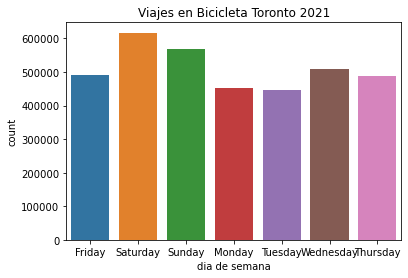

In [7]:
#Día de la semana con mayor número de viajes.
sns.countplot(x=df['dia de semana'], data=df)
plt.title('Viajes en Bicicleta Toronto 2021')
str(df['dia de semana'].value_counts().index[0:1])
   

Como primera impresión, podemos ver que la tendencia de viajes confirma la tesis "popular", de que en el periodo del fin de semana, el volumen de viajes se alza frente al resto de los días.

"Int64Index([8], dtype='int64')"

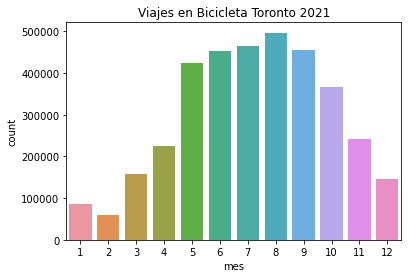

In [8]:
#Mes con mayor número de viajes.
sns.countplot(x=df['mes'], data=df)
plt.title('Viajes en Bicicleta Toronto 2021')
str(df['mes'].value_counts().index[0:1])

Y también, en base al gráfico aperturado por mes, nos confirma que la tendencia de viajes es y responde a una estacionalidad, teniendo en cuenta que estamos hablando de una ciudad que está en el hemisferio norte, el volumen de viajes se concentra en su temporada "Primavera/Verano", hallando un cuantioso salto entre el mes de Abril (primer mes de primavera en Toronto), con Mayo hasta Octubre, que es cuando comienza la etapa de Otoño. Nuevamente confirmando que el servicio si bien es usado, obedece a variables estacionarias.

"Int64Index([17], dtype='int64')"

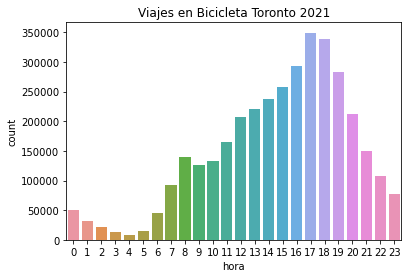

In [9]:
#Hora del día con mayor numero de viajes
sns.countplot(x=df['hora'], data=df)
plt.title('Viajes en Bicicleta Toronto 2021')
str(df['hora'].value_counts().index[0:1])

De acuerdo al gráfico podemos observar que el horario con mayor recurrencia de uso del servicio, es entre las 16 y las 19 horas, siendo el peak las 17:00 horas.

Text(0.5, 1.0, 'Viajes en Bicicleta Toronto 2021')

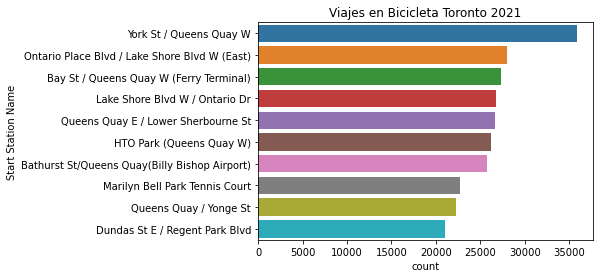

In [10]:
#Top 10 estaciones de salida con mayor número de viajes
sns.countplot(y=df['Start Station Name'], order = df['Start Station Name'].value_counts().index[0:10],  data=df)
plt.title('Viajes en Bicicleta Toronto 2021')

Text(0.5, 1.0, 'Viajes en Bicicleta Toronto 2021')

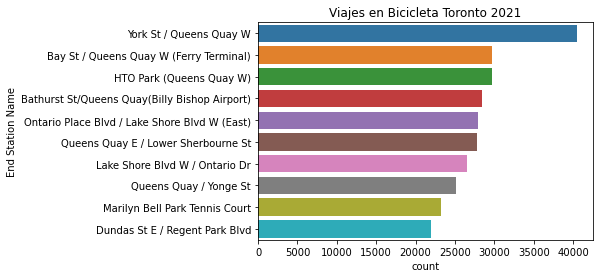

In [11]:
#Top 10 estaciones de llegada con mayor número de viajes
sns.countplot(y=df['End Station Name'], order = df['End Station Name'].value_counts().index[0:10],  data=df)
plt.title('Viajes en Bicicleta Toronto 2021')


En base al registro de los dos gráficos anteriores en donde se muestran las estaciones con más viajes de salidas y más llegadas de sus usuarios, la tendencia suele ser similar, pero en ambas destaca que la estación "York ST/Queens Quay W",  es la que tiene más número de viajes en ambos casos, pudiendo inferir en ésto, que esta estación es la más popular de Toronto.

# Predicción usando serie de tiempo

Una vez analizado el contexto del servicio de bicicletas en Toronto, se decidió estudiar la estación más popular: "York ST/Queens Quay W" y en base a esta, desarrollaremos la predicción de tiempo, éstos con los modelos ARMA y ARIMA, en primera instancia para proyectar el uso de la estación más popular, utilizando ambos métodos de predicción y luego, para predecir el uso diario de las bicicletas durante los meses de Enero y Febrero del año 2022.

Filtraremos nuesto dataframe para analizar solo la estación York ST/Queens Quay W, la cual se determinó fue la más concurrida durante el año.

In [12]:
#Dataframe con la estación de salida mas usada
df_station = df[df['Start Station Name']== 'York St / Queens Quay W']
df_station.pop('Unnamed: 0')
df_station

,Trip Duration,Start Station Name,End Station Name,hora,fecha,dia,mes,dia de semana
556,448,York St / Queens Quay W,Little Norway Park,12,2021-01-01,1,1,Friday
619,1159,York St / Queens Quay W,Madison Ave / Bloor St W,12,2021-01-01,1,1,Friday
700,651,York St / Queens Quay W,Wellington St W / Portland St,13,2021-01-01,1,1,Friday
1157,3176,York St / Queens Quay W,York St / Lake Shore Blvd W,15,2021-01-01,1,1,Friday
1238,996,York St / Queens Quay W,York St / Queens Quay W,15,2021-01-01,1,1,Friday
...,...,...,...,...,...,...,...,...
3574588,1417,York St / Queens Quay W,HTO Park (Queens Quay W),20,2021-12-31,31,12,Friday
3574589,1408,York St / Queens Quay W,HTO Park (Queens Quay W),20,2021-12-31,31,12,Friday
3574591,1399,York St / Queens Quay W,HTO Park (Queens Quay W),20,2021-12-31,31,12,Friday
3574594,1361,York St / Queens Quay W,HTO Park (Queens Quay W),20,2021-12-31,31,12,Friday


Crearemos un dataframe con la duración de viaje promedio para cada día

In [13]:
#Dataframe con valores promedio por día 
means = df_station.groupby('fecha', as_index=False ).mean()
means

,fecha,Trip Duration,hora,dia,mes
0,2021-01-01,1350.500000,14.000000,1.0,1.0
1,2021-01-02,958.142857,16.285714,2.0,1.0
2,2021-01-03,883.750000,16.625000,3.0,1.0
3,2021-01-04,1072.857143,14.285714,4.0,1.0
4,2021-01-05,1252.333333,13.611111,5.0,1.0
...,...,...,...,...,...
360,2021-12-27,864.545455,13.090909,27.0,12.0
361,2021-12-28,786.550000,13.500000,28.0,12.0
362,2021-12-29,824.500000,13.583333,29.0,12.0
363,2021-12-30,615.300000,14.700000,30.0,12.0


Y otro DataFrame donde tendremos la cantidad de viajes que se realizaron en la estación cada día

In [14]:
#Juntamos frecuencias por día.
val = df_station['fecha'].value_counts().sort_index()
df2 = val.to_frame()
df2 = df2.rename(columns={'fecha':'count'})
df2

,count
2021-01-01,6
2021-01-02,7
2021-01-03,8
2021-01-04,14
2021-01-05,18
...,...
2021-12-27,11
2021-12-28,20
2021-12-29,12
2021-12-30,10


Crearemos un dataframe con las fechas que queremos predecir, en este caso lo haremos para los meses Enero y Febrero del año 2022

In [15]:
#Lista con fechas para predecir
prueba = datetime.datetime.strptime("2022-01-01", "%Y-%m-%d")
fecha_predic = pd.date_range(prueba, periods=59)
fecha_predic = pd.DataFrame(fecha_predic, columns=['fecha'])
fecha_predic['fecha'] = fecha_predic['fecha'].dt.date

fecha_predic = fecha_predic['fecha'].value_counts().sort_index()
fecha_predic = fecha_predic.to_frame()
fecha_predic = fecha_predic.rename(columns={'fecha':'count'})
fecha_predic.index 

Index([2022-01-01, 2022-01-02, 2022-01-03, 2022-01-04, 2022-01-05, 2022-01-06,
       2022-01-07, 2022-01-08, 2022-01-09, 2022-01-10, 2022-01-11, 2022-01-12,
       2022-01-13, 2022-01-14, 2022-01-15, 2022-01-16, 2022-01-17, 2022-01-18,
       2022-01-19, 2022-01-20, 2022-01-21, 2022-01-22, 2022-01-23, 2022-01-24,
       2022-01-25, 2022-01-26, 2022-01-27, 2022-01-28, 2022-01-29, 2022-01-30,
       2022-01-31, 2022-02-01, 2022-02-02, 2022-02-03, 2022-02-04, 2022-02-05,
       2022-02-06, 2022-02-07, 2022-02-08, 2022-02-09, 2022-02-10, 2022-02-11,
       2022-02-12, 2022-02-13, 2022-02-14, 2022-02-15, 2022-02-16, 2022-02-17,
       2022-02-18, 2022-02-19, 2022-02-20, 2022-02-21, 2022-02-22, 2022-02-23,
       2022-02-24, 2022-02-25, 2022-02-26, 2022-02-27, 2022-02-28],
      dtype='object')

# Modelado de cantidad de viajes por dia

Graficaremos el dataframe de cantidad de viajes por día para darnos uan idea de como son los datos

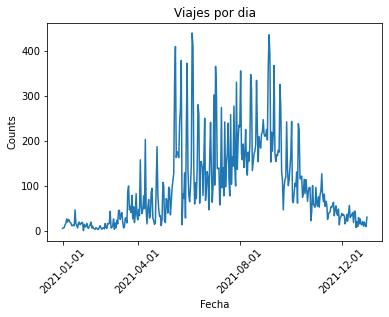

In [16]:
#Lineplot 
plt.plot(df2.index, df2['count'])
plt.ylabel('Counts')
plt.xlabel('Fecha')
plt.xticks(['2021-01-01','2021-04-01','2021-08-01','2021-12-01'], rotation = 45)
plt.title("Viajes por dia")
plt.show()

Observamos que existe mucha dispersión en estos datos por lo que decidimos aplicar un método de suavizado usando convolución lineal y utilizando 20 medias móviles. Luego graficamos nuevamente los resultados obtenidos

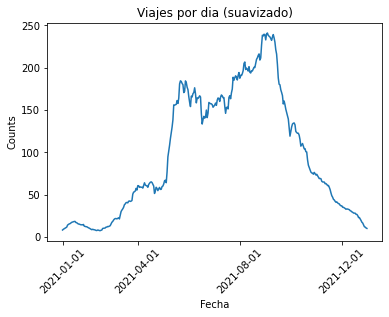

In [17]:
#Datos suavizados
def smooth(y, promedios):
    prom  = np.ones(promedios)/promedios
    y_smooth = np.convolve(y, prom, mode='same')
    return y_smooth

count_suav = smooth(df2['count'], 20)

#dataframe con datos suavizados
df_suave = pd.DataFrame(count_suav, columns=['count'])

#Lineplot 
plt.plot(df2.index, count_suav)
plt.ylabel('Counts')
plt.xlabel('Fecha')
plt.xticks(['2021-01-01','2021-04-01','2021-08-01','2021-12-01'], rotation = 45)
plt.title("Viajes por dia (suavizado)")
plt.show()

Observamos que la gráfica tiene mucha menos dispersión. 

Para los datos de entrenamiento y prueba, se condideraron los siguientes rangos de fechas:
<br>En el caso de Entrenamiento, desde el 01/01/2021 hasta el 01/11/2021, mientras que la prueba, abarcará el periodo restante del año 2021, es decir, desde el 01/11/2021 hasta el 31/12/2021.<br><br>
Una vez separados ambos subsets se procedió a aplicar el mismo método de suavizado a los datos, luego se graficaron ambos

C:\Users\mc_mo\AppData\Local\Temp\ipykernel_8840\1101145936.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['count'] = smooth(test['count'], 20)
C:\Users\mc_mo\AppData\Local\Temp\ipykernel_8840\1101145936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['count'] = smooth(train['count'], 20)


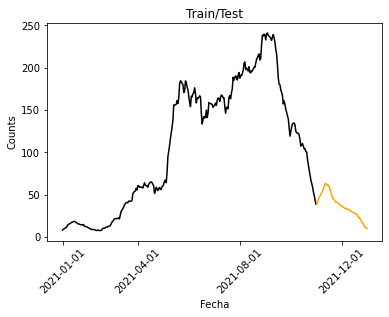

In [18]:
#Entrenamiento y testeo
train = df2[df2.index < "2021-11-01"]
test = df2[df2.index >= "2021-11-01"]

#Suavizado de testeo y entrenamiento
test['count'] = smooth(test['count'], 20)
train['count'] = smooth(train['count'], 20)

#Gráfico de testeo y entrenamiento
plt.plot(train, color = "black")
plt.plot(test, color = "Orange")
plt.ylabel('Counts')
plt.xlabel('Fecha')
plt.xticks(['2021-01-01','2021-04-01','2021-08-01','2021-12-01'], rotation = 45)
plt.title("Train/Test")
plt.show()

## Modelo ARMA

Comenzaremos evaluando el modelo ARMA, para esto se utilizó el subset "train" para entrenarlo y luego se realizó un dataframe utilizando un modelo discreto de regresión lineal con un intervalo de confianza del 95% para poder testear la predicción del modelo usando el subset "test". <br>
Luego se graficaron los datos de testeo y entrenamiento junto con los predichos(color verde).

C:\Users\mc_mo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mc_mo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


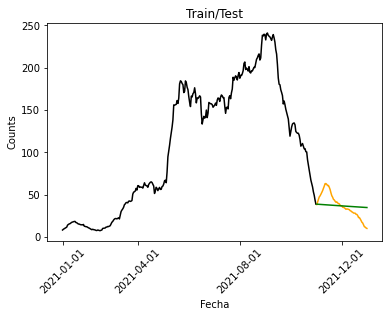

In [19]:
arma = SARIMAX(train)
arma = arma.fit()

arma_pred = arma.get_forecast(len(test.index))
#Un 95% de confianza
arma_pred_df = arma_pred.conf_int(alpha = 0.05) 
arma_pred_df["Prediccion"] = arma.predict(start = arma_pred_df.index[0], end = arma_pred_df.index[-1])
arma_pred_df.index = test.index
arma_pred_out = arma_pred_df["Prediccion"]

#Gráficos
plt.plot(train, color = "black")
plt.plot(test, color = "Orange")
plt.plot(arma_pred_out, color='green', label = 'Predictions')
plt.ylabel('Counts')
plt.xlabel('Fecha')
plt.xticks(['2021-01-01','2021-04-01','2021-08-01','2021-12-01'], rotation = 45)
plt.title("Train/Test")
plt.show()

Calculamos el error cuadrático medio y obtenemos el resumen del modelo ya entrenado para poder comparar la factibilidad de su uso.

In [20]:
#Error cuadrático medio
arma_error = np.sqrt(mean_squared_error(test["count"].values, arma_pred_df["Prediccion"]))
print("Error cuadrático medio: ",arma_error)
arma.summary()

Error cuadrático medio:  13.233239223118419


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                  304
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -915.772
Date:                Tue, 18 Oct 2022   AIC                           1835.544
Time:                        23:16:01   BIC                           1842.978
Sample:                    01-01-2021   HQIC                          1838.518
                         - 10-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9982      0.002    622.757      0.000       0.995       1.001
sigma2        23.7694      1.262     18.839      0.000      21.296      26.242
===================================================================================
Ljung-Box (L1) (Q):                  33.34   Jarque-Bera (JB):                95.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.61   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Modelo ARIMA

Primero utilizaremos autoARIMA, el cual nos entregará los valores óptimos para los parametros p, d y q del modelo ARIMA

In [21]:
#Usaremos primero AutoARIMA
autoarima = auto_arima(train, start_P=0, start_Q=0)
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  304
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -882.150
Date:                Tue, 18 Oct 2022   AIC                           1772.300
Time:                        23:16:03   BIC                           1787.142
Sample:                    01-01-2021   HQIC                          1778.239
                         - 10-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6581      0.044    -14.847      0.000      -0.745      -0.571
ma.L2         -0.3479      0.052     -6.687      0.000      -0.450      -0.246
ma.L3          0.1357      0.047      2.914      0.004       0.044       0.227
sigma2        20.0729      1.148     17.487      0.000      17.823      22.323
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                55.92
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              10.49   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Observamos que nos entrega los valores (0,2,3) para p, d y q respectivamente, por lo que que entrenó el modelo ARIMA usando estos parámetros y siguiendo el procedimiento igual que en el modelo ARMA ya explicado.

C:\Users\mc_mo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mc_mo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mc_mo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


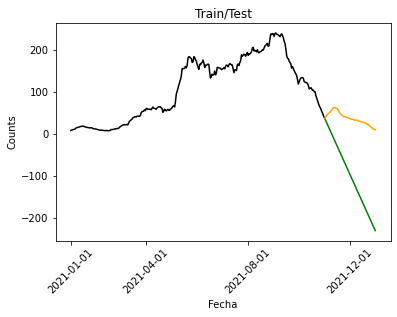

In [22]:
arima = ARIMA(train,order = (0, 2, 3))
arima = arima.fit()

arima_pred = arima.get_forecast(len(test.index))
#Un 95% de confianza
arima_pred_df = arima_pred.conf_int(alpha = 0.05) 
arima_pred_df["Prediccion"] = arima.predict(start = arima_pred_df.index[0], end = arima_pred_df.index[-1])
arima_pred_df.index = test.index
arima_pred_out = arima_pred_df["Prediccion"] 
 
    
plt.plot(train, color = "black")
plt.plot(test, color = "Orange")
plt.plot(arima_pred_out, color='green', label = 'Predictions')
plt.ylabel('Counts')
plt.xlabel('Fecha')
plt.xticks(['2021-01-01','2021-04-01','2021-08-01','2021-12-01'], rotation = 45)
plt.title("Train/Test")
plt.show()

In [23]:
#Error cuadrático medio
arima_error = np.sqrt(mean_squared_error(test["count"].values, arima_pred_df["Prediccion"]))
print("Error cuadratico medio: ",arima_error)
arima.summary()

Error cuadratico medio:  150.40021836894522


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                  304
Model:                 ARIMA(0, 2, 3)   Log Likelihood                -882.150
Date:                Tue, 18 Oct 2022   AIC                           1772.300
Time:                        23:16:03   BIC                           1787.142
Sample:                    01-01-2021   HQIC                          1778.239
                         - 10-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6581      0.044    -14.847      0.000      -0.745      -0.571
ma.L2         -0.3479      0.052     -6.687      0.000      -0.450      -0.246
ma.L3          0.1357      0.047      2.914      0.004       0.044       0.227
sigma2        20.0729      1.148     17.487      0.000      17.823      22.323
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                55.92
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              10.49   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Observamos que el error cuadrático medio y los valores para el módelo ARIMA(AIC=1772.300, BIC=1787.142, ECM= 150.4) son mucho mayores que los del módelo ARMA (AIC=1772.300, BIC=1787.142, ECM=13.2) por lo que optamos por predecir usando este último.

# Prediccion usando ARMA

Usaremos nuestro dataframe anteriormente creado con las fechas llamado "fecha_predic" para aplicarlo a nuestro modelo y predecir los valores.

In [24]:
#Predicción
arma_pred = arma.get_forecast(len(fecha_predic.index))
#Un 95% de confianza
arma_pred_df = arma_pred.conf_int(alpha = 0.05) 
arma_pred_df["Prediccion"] = arma.predict(start = arma_pred_df.index[0], end = arma_pred_df.index[-1])
arma_pred_df.index = fecha_predic.index

In [25]:
#Resultado promedio de la prediccion
arma_pred_df['Prediccion'].mean()

37.0257140024825

# Modelado de tiempo de viaje por día 

In [26]:
means.pop('hora')
means.pop('mes')
means.pop('dia')
means.set_index('fecha', inplace=True)
means

,Trip Duration
fecha,
2021-01-01,1350.500000
2021-01-02,958.142857
2021-01-03,883.750000
2021-01-04,1072.857143
2021-01-05,1252.333333
...,...
2021-12-27,864.545455
2021-12-28,786.550000
2021-12-29,824.500000


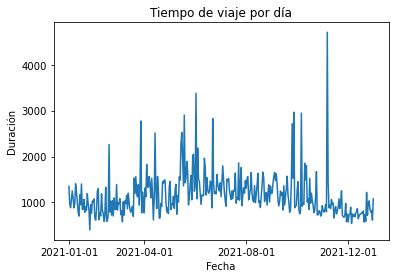

In [27]:
#Gráfico de línea Duración vs Día

plt.plot(means.index, means['Trip  Duration'])
plt.ylabel('Duración')
plt.xlabel('Fecha')
plt.xticks(['2021-01-01','2021-04-01','2021-08-01','2021-12-01'])
plt.title("Tiempo de viaje por día")
plt.show()

Se aplica una transformación para obtener la primera diferencia del Dataset en estudio.

In [28]:
coso = means['Trip  Duration'].diff()
coso

fecha
2021-01-01           NaN
2021-01-02   -392.357143
2021-01-03    -74.392857
2021-01-04    189.107143
2021-01-05    179.476190
                 ...    
2021-12-27   -170.978355
2021-12-28    -77.995455
2021-12-29     37.950000
2021-12-30   -209.200000
2021-12-31    462.054839
Name: Trip  Duration, Length: 365, dtype: float64

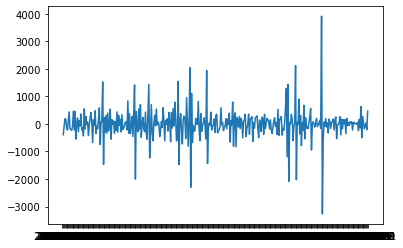

In [29]:
plt.plot(coso)
plt.show()

Crearemos 2 nuevos subsets de entrenamiento y testeo usando el dataframe con los promedios por día ya calculados

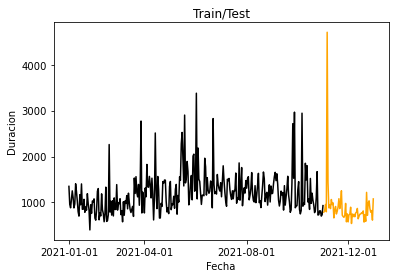

In [30]:
#Entrenamiento y testeo
train2 = means[means.index < "2021-11-01"]
test2 = means[means.index > "2021-11-01"]

#Gráfico de testeo y entrenamiento
plt.plot(train2, color = "black")
plt.plot(test2, color = "Orange")
plt.ylabel('Duracion')
plt.xlabel('Fecha')
plt.xticks(['2021-01-01','2021-04-01','2021-08-01','2021-12-01'])
plt.title("Train/Test")
plt.show()

## Modelo ARMA


El procedimiento para entrenamiento de los módelos es el mismo que ya realizamos, solo que utilizando el nuevo dataframe con datos  de el tiempo medio.

C:\Users\mc_mo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mc_mo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


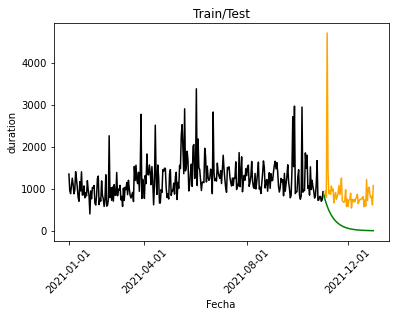

In [31]:
arma = SARIMAX(train2)
arma = arma.fit()

arma_pred = arma.get_forecast(len(test2.index))
#Un 95% de confianza
arma_pred_df = arma_pred.conf_int(alpha = 0.05) 
arma_pred_df["Prediccion"] = arma.predict(start = arma_pred_df.index[0], end = arma_pred_df.index[-1])
arma_pred_df.index = test2.index
arma_pred_out = arma_pred_df["Prediccion"]

#Gráficos sobrepuestos
plt.plot(train2, color = "black")
plt.plot(test2, color = "Orange")
plt.plot(arma_pred_out, color='green', label = 'Predictions')
plt.ylabel('duration')
plt.xlabel('Fecha')
plt.xticks(['2021-01-01','2021-04-01','2021-08-01','2021-12-01'], rotation = 45)
plt.title("Train/Test")
plt.show()

In [32]:
#Error cuadrático medio
arma_error = np.sqrt(mean_squared_error(test2["Trip  Duration"].values, arma_pred_df["Prediccion"]))
print("Error cuadratico medio: ",arma_error)
arma.summary()

Error cuadratico medio:  882.5037728364435


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Trip  Duration   No. Observations:                  304
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2335.898
Date:                Tue, 18 Oct 2022   AIC                           4675.796
Time:                        23:16:09   BIC                           4683.230
Sample:                    01-01-2021   HQIC                          4678.770
                         - 10-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9121      0.017     53.030      0.000       0.878       0.946
sigma2      2.748e+05   1.27e+04     21.552      0.000     2.5e+05       3e+05
===================================================================================
Ljung-Box (L1) (Q):                  71.08   Jarque-Bera (JB):               260.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.12
Prob(H) (two-sided):                  0.09   Kurtosis:                         7.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Modelo ARIMA

Para este modelo se decidió no realizar autoARIMA y ajustar los parametros p,d y q de forma directa optando finalmente por (1,2,1)

C:\Users\mc_mo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mc_mo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mc_mo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


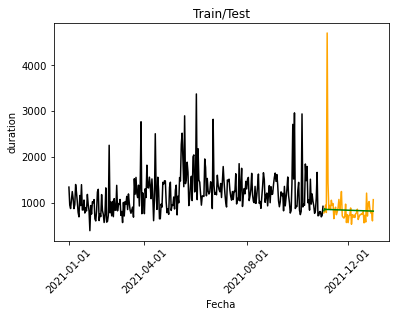

In [33]:
arima = ARIMA(train2,order = (1, 2, 1))
arima = arima.fit()

arima_pred = arima.get_forecast(len(test2.index))
#Un 95% de confianza
arima_pred_df = arima_pred.conf_int(alpha = 0.05) 
arima_pred_df["Prediccion"] = arima.predict(start = arima_pred_df.index[0], end = arima_pred_df.index[-1])
arima_pred_df.index = test2.index
arima_pred_out = arima_pred_df["Prediccion"] 
 
    
plt.plot(train2, color = "black")
plt.plot(test2, color = "Orange")
plt.plot(arima_pred_out, color='green', label = 'Predictions')
plt.ylabel('duration')
plt.xlabel('Fecha')
plt.xticks(['2021-01-01','2021-04-01','2021-08-01','2021-12-01'], rotation = 45)
plt.title("Train/Test")
plt.show()

In [34]:
#Error cuadrático medio
arima_error = np.sqrt(mean_squared_error(test2["Trip  Duration"].values, arima_pred_df["Prediccion"]))
print("Error cuadratico medio: ",arima_error)
arima.summary()

Error cuadratico medio:  524.7046581415658


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Trip  Duration   No. Observations:                  304
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -2289.364
Date:                Tue, 18 Oct 2022   AIC                           4584.728
Time:                        23:16:09   BIC                           4595.859
Sample:                    01-01-2021   HQIC                          4589.182
                         - 10-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4820      0.033    -14.602      0.000      -0.547      -0.417
ma.L1         -1.0000      0.047    -21.155      0.000      -1.093      -0.907
sigma2      2.205e+05   2.14e-07   1.03e+12      0.000    2.21e+05    2.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.47   Jarque-Bera (JB):               243.86
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.94
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.69e+26. Standard errors may be unstable.
"""

Observamos que el error cuadrático medio y los valores para el módelo ARMA(AIC=4675.796, BIC=4683.230, ECM=886.3) son mucho mayores que los del módelo ARIMA (AIC=4584.728, BIC=4595.859, ECM=520.2) por lo que optamos por predecir usando este último.

## Predicción usando ARIMA

El mismo procedimiento de predicción usado en el caso anterior.

In [35]:
#Predicción
arima_pred = arima.get_forecast(len(fecha_predic.index))
#Un 95% de confianza
arima_pred_df = arima_pred.conf_int(alpha = 0.05) 
arima_pred_df["Prediccion"] = arima.predict(start = arima_pred_df.index[0], end = arima_pred_df.index[-1])
arima_pred_df.index = fecha_predic.index

In [36]:
#Resultado promedio de la predicción 
arima_pred_df["Prediccion"].mean()

846.8607965639925

# Conclusiones 

A partir de los resultados de la predicción realizados respecto del número de viajes se concluye que para los meses de   Enero y Febrero del 2022, se muestra una tendencia decreciente de uso de bicicletas, ésto debido a que la proyección se generó y se proyectó en base a un año de estudio, ésto hace que el modelo no se base en un ciclo anual de temporalidad/estacionalidad, como para que se entrene y genere una tendencia de año a año de que en ciertos periodos cae la demanda y luego tiene un alza en los periodos estivales, es por esto que el modelo sólo fija una mirada decrecimiente en el uso, ya que no hay un "bucle" de información de estaciones para que se estudie la tendencia por temporadas.
  
De acuerdo a los resultados obtenidos los horarios con mayor recurrencia de uso del servicio de bicicletas es entre las 16 y las 19 horas, siendo el peak las 17:00 horas.   Los días con mayor frecuencia de uso en orden descendente : Sábados, Domingos y Viernes.

Las diez estaciones de origen con mayor número de viajes son: York St / Queens Quay W, Bay St / Queens Quay W (Ferry Terminal),HTO Park (Queens Quay W),Bathurst St/Queens Quay(Billy Bishop Airport,Ontario Place Blvd / Lake Shore Blvd W (East),Queens Quay E / Lower Sherbourne St, Lake Shore Blvd W / Ontario Dr,Queens Quay / Yonge St, Marilyn Bell Park Tennis Court,Dundas St E / Regent Park Blvd.

Las diez estaciones destino con mayor número viajes son: York St / Queens Quay W,Ontario Place Blvd / Lake Shore Blvd W (East)',Bay St / Queens Quay W (Ferry Terminal),Lake Shore Blvd W / Ontario Dr, Queens Quay E / Lower Sherbourne St,HTO Park (Queens Quay W),Bathurst St/Queens Quay(Billy Bishop Airport,Marilyn Bell Park Tennis Court, Queens Quay / Yonge St y Dundas St E / Regent Park Blvd.

Se realiza predicción para la estación más concurrida "York St / Queens Quay W", aplicando el  modelo ARIMA con los parámetros p,d y q (1,2,1) que predicen que para los meses de enero y febrero del año 2022 se proyecta un tiempo promedio de viaje por día de 846.86.

Mientras que para el promedio de los números de viajes predichos para los meses en estudio en el año 2022, las variables usadas para ARMA fueron las predeterminadas por el modelo, cuyo resultado obtenido fue un promedio de 37.3 viajes diarios.

# Limitaciones

Las limitaciones fueron los periodos de las estacionalidades, es decir, haber estudiado un dataset más que incluya otros años y haber podido incluir el efecto comparativo estacional en el uso de las bicicletas, es decir, que  llegado cierto periodo el modelo  predijera  el  decrecimiento o aumento del uso de bicicletas.

Si se complementara el análisis con un dataset que contemple el número de habitantes por zona ,  ubicación geográfica, distancia entre las estaciones, entre otras se podría realizar un estudio de la proporcionalidad del número de viajes versus el número de habitantes por zona para estudiar  la correlación de estas variables respecto de la demanda del uso de bicicletas de cada estación.

Asi también,  el tiempo de espera por usuario, para la obtención de una bicicleta para determinar si la estación cuenta con un número adecuado  para cubrir la demanda de este servicio y como esto afecta la cantidad de viajes realizados por estación en función a la oferta.



